In [45]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import flask
import seaborn as sns

In [46]:
import numpy as np
import pandas as pd

In [47]:
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.sql import text

In [49]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#first get the maximum date from our sample data to see how up-to-date it is
results = engine.execute('SELECT max(date) from Measurement').fetchall()

max_date = results[0][0]

end_date = datetime.strptime(max_date, '%Y-%m-%d').date()

first_date = end_date - dt.timedelta(days=365)

first_date = datetime.strftime(first_date, '%Y-%m-%d')

print(f"12 Month Date Range: {first_date} - {end_date}")



12 Month Date Range: 2016-08-23 - 2017-08-23


In [55]:
#Now query the precipitation data using the 12-month date range

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date > first_date).\
    filter(Measurement.date < end_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results[:])

df = df.set_index('date')

# Sort the dataframe by date
df = df.sort_values('date')
df = df.rename(columns={'prcp' : 'precipitation'})

df.head(10)



,station,precipitation,tobs
date,,,
2016-08-24,USC00519397,0.08,79.0
2016-08-24,USC00513117,2.15,76.0
2016-08-24,USC00514830,2.28,80.0
2016-08-24,USC00517948,NaN,78.0
2016-08-24,USC00519523,1.22,79.0
2016-08-24,USC00519281,2.15,77.0
2016-08-24,USC00516128,1.45,74.0
2016-08-25,USC00519397,0.08,80.0
2016-08-25,USC00513117,0.08,77.0


In [56]:
#We need to plot only the precipitation and date so get rid of the station and tobs columns
# then group the data by date and summarize the precipitation

df_rain_plot = df.drop(columns=['station', 'tobs'])

df_rain_groupby = df_rain_plot.groupby('date').sum()
df_rain_groupby.reset_index(level=0, inplace=True)

df_rain_groupby.head(10)



,date,precipitation
0,2016-08-24,9.33
1,2016-08-25,0.54
2,2016-08-26,0.10
3,2016-08-27,0.32
4,2016-08-28,3.10
5,2016-08-29,1.46
6,2016-08-30,0.07
7,2016-08-31,3.18
8,2016-09-01,0.03
9,2016-09-02,0.25


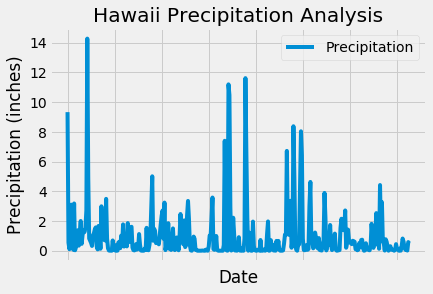

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data

df_rain_groupby.plot('date', 'precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Hawaii Precipitation Analysis')
plt.legend(['Precipitation'])
plt.savefig('Images/Hawaii_Precipitation_Analysis.png')
plt.show()


In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation,tobs
count,2011.000000,2219.000000
mean,0.176549,74.568725
std,0.460667,4.608881
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


In [59]:
# How many stations are available in this dataset?
station_number = engine.execute('SELECT count(station) as "Number of Stations" from (SELECT DISTINCT Measurement.station FROM Measurement)').fetchall()

station_number = station_number[0][0]
station_number


print("There are {} stations.".format(station_number))

There are 9 stations.


In [60]:
# What are the most active stations?
# List the stations and the counts in descending order.

most_active = engine.execute(
    'SELECT Measurement.station, COUNT(*) FROM Measurement GROUP BY Measurement.station ORDER BY COUNT(*) DESC').fetchall()

most_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [61]:
#Get the most active station
top_station = most_active[0][0]
top_station

print(f'The most active station is {top_station}.')

The most active station is USC00519281.


In [62]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature  active station?

t = text("SELECT MIN(Measurement.tobs), MAX(Measurement.tobs), AVG(Measurement.tobs), Measurement.station \
               FROM Measurement WHERE Measurement.station = :z and Measurement.date between :x and :y")


top_station_results = engine.execute(t, z=top_station, x=first_date, y=end_date).fetchall()

top = top_station_results[0]
top

min_temp = top[0]
max_temp = top[1]
avg_temp = round(top[2],2)

print(f'12-Month Stats for the Most Active Station ({top_station})\nLowest temp: {min_temp}\nHighest temp: {max_temp}\nAverage temp: {avg_temp}')


12-Month Stats for the Most Active Station (USC00519281)
Lowest temp: 59.0
Highest temp: 83.0
Average temp: 73.11


In [63]:
# Choose the station with the highest number of temperature observations.

top_station_vals = engine.execute(
    'select max(x.observation), x.station from (select count(*) as observation, station \
    from Measurement group by station) x').fetchall()


top_station = [station for (number, station) in top_station_vals]
top_station = top_station[0]
top_station
               
    
print(f'The station with the most observations is : {top_station}')    

The station with the most observations is : USC00519281


In [65]:
# Query the last 12 months of temperature observation data for this station


s = text("select count(*) as 'frequency', Measurement.tobs from Measurement"
             " where Measurement.date between :a and :b and Measurement.station = :c"
            " group by Measurement.tobs")

station_results = engine.execute(s, a=first_date, b=end_date, c=top_station).fetchall()
station_results

top_station_df = pd.DataFrame(station_results, columns=['Frequency', 'Tobs'])

#top_station_df = top_station_df.set_index('Frequency')

top_station_df = top_station_df.astype(int)
top_station_df.head()



,Frequency,Tobs
0,3,59
1,2,60
2,1,61
3,6,62
4,4,63


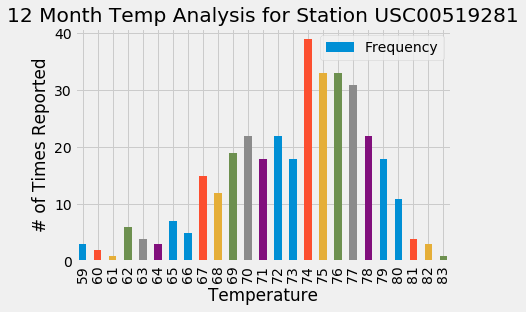

In [66]:
#Plot the above dataframe results

top_station_df.plot.bar(x="Tobs", y="Frequency")
plt.title(f"12 Month Temp Analysis for Station {top_station}")
plt.ylabel("# of Times Reported")
plt.xlabel("Temperature")
plt.legend()
plt.savefig('Images/12 Month Analysis Top Station.png')

In [67]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-07-01', '2017-07-31'))

[(69.0, 78.48453608247422, 87.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#My trip dates are July 15, 2017 to July 31, 2017, so the prior year is 2016.

prior_temps = calc_temps('2016-07-15', '2016-07-31')

prior_temps


[(71.0, 77.78, 83.0)]

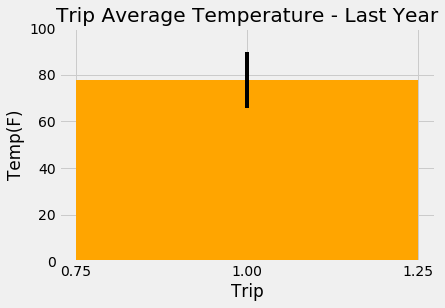

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#Put the last year stats into variables
last_avg = prior_temps[0][1]
last_min = prior_temps[0][0]
last_max = prior_temps[0][2]

#Calculate the difference between the min and max to get the error bar
min_max = last_max - last_min

fig, ax = plt.subplots()
bar_plot = ax.bar(1 , last_avg, color= 'orange', yerr=min_max, width=.5)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp(F)")
ax.set_title("Trip Average Temperature - Last Year")
plt.ylim(0, 100)
plt.locator_params(axis='x', nbins=1)
plt.savefig('Images/Last Year Trip Avg.png')
plt.show()



In [70]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


h = text("select Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, " 
         " sum(Measurement.prcp) as 'precipitation' from Measurement, Station "
             " where Measurement.station = Station.station and Measurement.date between :d1 and :d2"
             " group by Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation "
             " order by precipitation desc")

station_data = engine.execute(h, d1='2016-07-15', d2='2016-07-31').fetchall()
station_data



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 16.54),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 13.58),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 9.2),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 6.22),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 5.25),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.57),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.51)]

## Optional Challenge Assignment

In [71]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs), Measurement.date]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0, '2011-01-01')]

In [72]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

my_trip_start = '2017-07-15'
my_trip_end = '2017-07-31'

# Use the start and end date to create a range of dates

start = dt.datetime(2017, 7, 15)
arr = np.array([start + dt.timedelta(days=i) for i in range(17)])
arr

# Strip off the year and save a list of %m-%d strings

md_list = []

for x in arr:
    my_date = str(x)
    d = dt.datetime.strptime(my_date, '%Y-%m-%d %H:%M:%S')
    d = d.strftime('%m-%d')
    md_list.append(d)
    
md_list

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for y in md_list:
    normals.append(daily_normals(y))

normals


[[(68.0, 76.2542372881356, 82.0, '2017-07-15')],
 [(70.0, 76.34482758620689, 83.0, '2015-07-16')],
 [(70.0, 76.30188679245283, 83.0, '2015-07-17')],
 [(72.0, 76.63793103448276, 83.0, '2017-07-18')],
 [(68.0, 75.89090909090909, 83.0, '2014-07-19')],
 [(69.0, 75.46296296296296, 82.0, '2016-07-20')],
 [(69.0, 76.9245283018868, 83.0, '2015-07-21')],
 [(69.0, 75.78846153846153, 81.0, '2017-07-22')],
 [(70.0, 76.20370370370371, 84.0, '2015-07-23')],
 [(69.0, 76.55555555555556, 81.0, '2015-07-24')],
 [(67.0, 76.89090909090909, 84.0, '2012-07-25')],
 [(71.0, 76.4423076923077, 86.0, '2012-07-26')],
 [(68.0, 76.58181818181818, 83.0, '2014-07-27')],
 [(69.0, 76.46428571428571, 82.0, '2015-07-28')],
 [(69.0, 76.47058823529412, 83.0, '2017-07-29')],
 [(69.0, 77.35185185185185, 84.0, '2017-07-30')],
 [(72.0, 77.03571428571429, 83.0, '2015-07-31')]]

In [73]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normal_list = [item for sublist in normals for item in sublist]
normal_list

normals_df = pd.DataFrame(normal_list, columns=['tmin', 'tavg', 'tmax', 'date'])
normals_df = normals_df.set_index('date')
normals_df

,tmin,tavg,tmax
date,,,
2017-07-15,68.0,76.254237,82.0
2015-07-16,70.0,76.344828,83.0
2015-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2014-07-19,68.0,75.890909,83.0
2016-07-20,69.0,75.462963,82.0
2015-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2015-07-23,70.0,76.203704,84.0


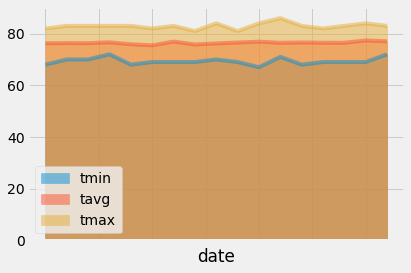

In [75]:
# Plot the daily normals as an area plot with `stacked=False`


normals_df.plot.area(stacked=False)
plt.savefig('Images/Area Plot For Trip Dates.png')